In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Stable Diffusion V2.1

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
    (a Python-3 GPU notebook with preinstalled HuggingFace/transformer libraries is recommended)
  </td>
</table>

## Overview

This notebook demonstrates running local inference for [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) on either [Colab](https://colab.research.google.com) or [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench). This notebook also demonstrates finetuning stabilityai/stable-diffusion-2-1 with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth) and deploying it on Vertex AI for online prediction.

### Objective

- Run local predictions for text-to-image and text-guided-image-to-image with serving dockers.
- Finetune the stabilityai/stable-diffusion-2-1 model with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth).
- Upload the model to [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model to a [Vertex AI Endpoint resource](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for text-to-image and text-guided-image-to-image.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

**NOTE**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Setup notebook

#### Colab only
Run the following commands for Colab and skip this section if you are using Workbench.

In [1]:
if "google.colab" in str(get_ipython()):
    ! pip3 install --upgrade google-cloud-aiplatform
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

! pip3 install --upgrade pip
! pip3 install torch==2.0.1+cu118  -f https://download.pytorch.org/whl/torch_stable.html
! pip3 install transformers==4.35.0
! pip3 install diffusers==0.22.3
! pip3 install datasets==2.9.0
! pip3 install accelerate==0.24.1

# Install gdown for downloading example training images.
! pip3 install gdown
# Remove wrong cublas version.
! pip3 uninstall nvidia_cublas_cu11 --yes

# Restart the notebook kernel after installs.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 726.1 kB/s eta 0:00:000:0100:02m
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 44.0 MB/s eta 0:00:0000:0100:01
  Created wheel for lit: file

{'status': 'ok', 'restart': True}

#### Workbench only
1.   Follow [this link](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb) to deploy the notebook to a Vertex AI Workbench Instance.
2.   Select `Create a new Notebook`.
3.   Click `Advanced Options`.
4.   In the **Environment** tab, select `Debian 10` for **Operating System** and select `Custom Container` for **Environment**.
5.   Set `Docker container image` to `us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/transformers-notebook`.
6.   Under **Machine configuration**, select 1 `T4` GPU and select `Install NVIDIA GPU driver automatically for me`.
7.   Click `Create` to create the Vertex AI Workbench instance.

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying fine tuned model to Vertex AI endpoint.

Fill following variables for experiments environment:

In [2]:
# Cloud project id.

# The region you want to launch jobs in.

# The Cloud Storage bucket for storing experiments output. Fill it without the 'gs://' prefix.
# GCS_BUCKET = ""  # @param {type:"string"}

# The service account for deploying fine tuned model.
# SERVICE_ACCOUNT = ""  # @param {type:"string"}

GCP_PROJECT= PROJECT_ID=project_id='my-project-0004-346516'
LOCATION = REGION = 'us-central1'

GCS_BUCKET = "gs://my-project-0004-346516/matchingengine/"

Initialize Vertex-AI API:

In [3]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

### Define constants

In [4]:
# The pre-built training docker image. It contains training scripts and models.
TRAIN_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-diffusers-train:latest"

# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-diffusers-serve-opt:20231213_0836_RC00"

### Define common functions

In [5]:
import base64
import glob
import os
from datetime import datetime
from io import BytesIO

import requests
from google.cloud import aiplatform, storage
from PIL import Image


def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = model_id
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-{task}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/diffusers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="g2-standard-8",
        accelerator_type="NVIDIA_L4",
        accelerator_count=1,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
    )
    return model, endpoint


def get_bucket_and_blob_name(filepath):
    # The gcs path is of the form gs://<bucket-name>/<blob-name>
    gs_suffix = filepath.split("gs://", 1)[1]
    return tuple(gs_suffix.split("/", 1))


def upload_local_dir_to_gcs(local_dir_path, gcs_dir_path):
    """Uploads files in a local directory to a GCS directory."""
    client = storage.Client()
    bucket_name = gcs_dir_path.split("/")[2]
    bucket = client.get_bucket(bucket_name)
    for local_file in glob.glob(local_dir_path + "/**"):
        if not os.path.isfile(local_file):
            continue
        filename = local_file[1 + len(local_dir_path) :]
        gcs_file_path = os.path.join(gcs_dir_path, filename)
        _, blob_name = get_bucket_and_blob_name(gcs_file_path)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(local_file)
        print("Copied {} to {}.".format(local_file, gcs_file_path))

## Upload and Deploy models

This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take ~15 minutes to complete. 

The first request requires some additional time for model compilation (up to a
few minutes), but the future requests should be processed much faster.

### Text-to-image

Deploy the stable diffusion model for the `text-to-image` task.

Once deployed, you can send a batch of text prompts to the endpoint to generated images.

When deployed on one `NVIDIA_L4` GPU, the averaged inference time of a request is ~3-4 seconds.

In [ ]:
# Set the model_id to "stabilityai/stable-diffusion-2-1" to load the OSS pre-trained model.
# model, endpoint = deploy_model(
#     model_id=f"gs://{GCS_BUCKET}/dreambooth/output", task="text-to-image"
# )

NOTE: The model weights will be downloaded after the deployment succeeds. Thus upto 10 minutes of additional waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

In [ ]:
# instances = [
#     {"prompt": "a deer in Matisse style"},
#     {"prompt": "a sks dog in Van Gogh style"},
# ]
# response = endpoint.predict(instances=instances)
# images = [base64_to_image(image) for image in response.predictions]
# image_grid(images)

Clean up resources:

In [ ]:
# # Undeploy model and delete endpoint.
# endpoint.delete(force=True)

# # Delete models.
# model.delete()

### Text-guided image-to-image

Deploy the stable diffusion model for the text-guided image-to-image task.

In [15]:
# Set the model_id to a GCS path, like "gs://GCS_BUCKET/dreambooth/output", to load the dreambooth finetuned model above.
model, endpoint = deploy_model(
    model_id="stabilityai/stable-diffusion-2-1", task="image-to-image"
)

Creating Endpoint
Create Endpoint backing LRO: projects/255766800726/locations/us-central1/endpoints/8451174025551413248/operations/5373647507756679168
Endpoint created. Resource name: projects/255766800726/locations/us-central1/endpoints/8451174025551413248
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/255766800726/locations/us-central1/endpoints/8451174025551413248')
Creating Model
Create Model backing LRO: projects/255766800726/locations/us-central1/models/6873581547878875136/operations/6706712997458345984
Model created. Resource name: projects/255766800726/locations/us-central1/models/6873581547878875136@1
To use this Model in another session:
model = aiplatform.Model('projects/255766800726/locations/us-central1/models/6873581547878875136@1')
Deploying model to Endpoint : projects/255766800726/locations/us-central1/endpoints/8451174025551413248
Deploy Endpoint model backing LRO: projects/255766800726/locations/us-central1/endpoints/84511740255514

NOTE: The model weights will be downloaded after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

In [16]:
print(model, "endpoint \n /n" ,endpoint )

resource name: projects/255766800726/locations/us-central1/models/6873581547878875136 endpoint 
 /n <google.cloud.aiplatform.models.Endpoint object at 0x7f9cc37955a0> 
resource name: projects/255766800726/locations/us-central1/endpoints/8451174025551413248


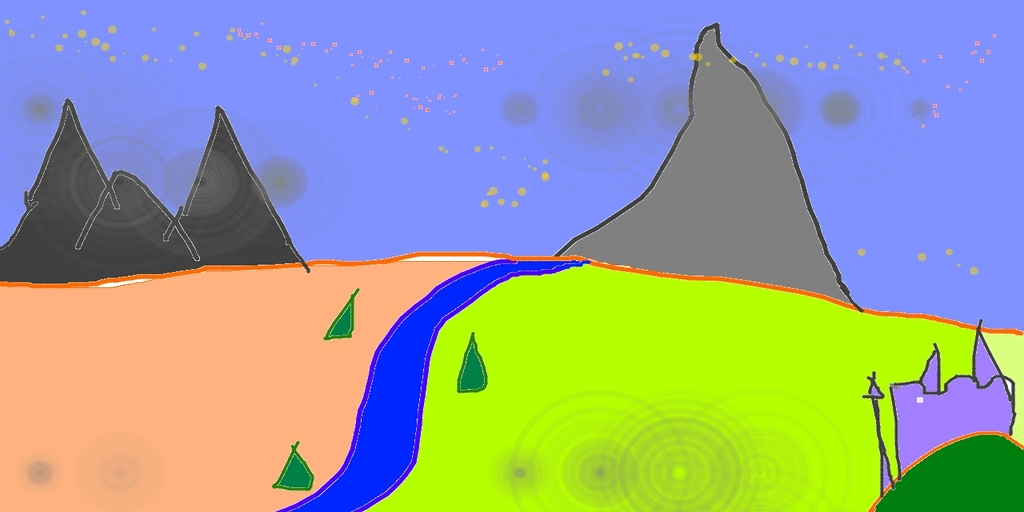

In [17]:
init_image = download_image(
    "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"
)
display(init_image)
instances = [
    {
        "prompt": "A fantasy landscape, trending on artstation with poop",
        "image": image_to_base64(init_image),
    },
]


In [19]:
response = endpoint.predict(instances=instances)
images = [base64_to_image(image) for image in response.predictions]
display(images[0])

InternalServerError: 500 {
  "code": 500,
  "type": "InternalServerException",
  "message": "Worker died."
}


In [25]:
from google.cloud import aiplatform

# Set the project and endpoint ID

endpoint_id = ENDPOINT_ID="6000089928355020800"
project = PROJECT_ID="255766800726"
INPUT_DATA_FILE="INPUT-JSON"

# Initialize the client
client = aiplatform.gapic.EndpointServiceClient(client_options={"api_endpoint": "us-central1-aiplatform.googleapis.com"})

# Get the Endpoint
endpoint = client.get_endpoint(name=f"projects/{project}/locations/us-central1/endpoints/{endpoint_id}")
endpoint

name: "projects/255766800726/locations/us-central1/endpoints/6000089928355020800"
display_name: "stabilityai_stable-diffusion-2-1-mg-one-click-deploy"
deployed_models {
  id: "118419601334730752"
  model: "projects/255766800726/locations/us-central1/models/stabilityai_stable-diffusion-2-1-1707320618125"
  display_name: "Stable Diffusion v2.1"
  create_time {
    seconds: 1707320638
    nanos: 515566000
  }
  dedicated_resources {
    machine_spec {
      machine_type: "g2-standard-8"
      accelerator_type: NVIDIA_L4
      accelerator_count: 1
    }
    min_replica_count: 1
    max_replica_count: 1
  }
  enable_access_logging: true
  model_version_id: "1"
}
traffic_split {
  key: "118419601334730752"
  value: 100
}
etag: "AMEw9yNf-2v_rJybUqVOU4RNW_mEs7y0z7lv-Fvp7MRjig-jcbNaCTq0QeNfK74T5CK4"
labels {
  key: "mg-one-click-deploy"
  value: "publishers-google-models-stable-diffusion-2-1"
}
labels {
  key: "versioned-mg-one-click-deploy"
  value: "publishers-google-models-stable-diffusion-2

In [22]:
endpoint

name: "projects/255766800726/locations/us-central1/endpoints/6000089928355020800"
display_name: "stabilityai_stable-diffusion-2-1-mg-one-click-deploy"
deployed_models {
  id: "118419601334730752"
  model: "projects/255766800726/locations/us-central1/models/stabilityai_stable-diffusion-2-1-1707320618125"
  display_name: "Stable Diffusion v2.1"
  create_time {
    seconds: 1707320638
    nanos: 515566000
  }
  dedicated_resources {
    machine_spec {
      machine_type: "g2-standard-8"
      accelerator_type: NVIDIA_L4
      accelerator_count: 1
    }
    min_replica_count: 1
    max_replica_count: 1
  }
  enable_access_logging: true
  model_version_id: "1"
}
traffic_split {
  key: "118419601334730752"
  value: 100
}
etag: "AMEw9yMJghOoiurtDSdm4ztRLZVy5ZWzXxkNStUdy3F_AVhISwd5sOM28HslYdPwLSCX"
labels {
  key: "mg-one-click-deploy"
  value: "publishers-google-models-stable-diffusion-2-1"
}
labels {
  key: "versioned-mg-one-click-deploy"
  value: "publishers-google-models-stable-diffusion-2

In [21]:
response = endpoint.predict(instances=instances)
images = [base64_to_image(image) for image in response.predictions]
display(images[0])

AttributeError: Unknown field for Endpoint: predict

In [ ]:
from google.cloud import aiplatform as ai

ai.init(project=PROJECT_ID, location=REGION)

In [36]:
from google.cloud import aiplatform_v1
from google.cloud import aiplatform

def sample_get_endpoint(name):
    # Create a client
    client = aiplatform_v1.EndpointServiceClient()

    # Initialize request argument(s)
    request = aiplatform_v1.GetEndpointRequest(
        name=name,
    )

    # Make the request
    response = client.get_endpoint(request=request)

    # Handle the response
    print(response)

In [37]:
name = "projects/{project}/locations/{location}/endpoints/{endpoint}"

name = "projects/255766800726/locations/us-central1/endpoints/6000089928355020800"
# name = "projects/255766800726/locations/us-central1/models/stabilityai_stable-diffusion-2-1-1707320618125"

In [38]:
sample_get_endpoint(name)

E0208 00:23:18.512411654  824973 hpack_parser.cc:999]                  Error parsing 'content-type' metadata: invalid value


Unknown: None Stream removed

Clean up resources:

In [ ]:
# # Undeploy model and delete endpoint.
# endpoint.delete()
